# Homework 9

## Utilities 

In [1]:
#Imports Libraries 
# complex networks package - guide https://networkx.org/ 
import networkx as nx

# visualization packages - https://matplotlib.org/ 
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.drawing.nx_agraph import graphviz_layout

# n-dinsional array tool - https://numpy.org/ 
import numpy as np

import matplotlib.colors as mcolors

import sklearn.manifold as sk

import sklearn.cluster as skc

import sklearn.decomposition as skd
import pandas as pd
import matplotlib.colors as mcolors

from node2vec import Node2Vec

import geopandas as gpd
# for Notebook
%matplotlib inline

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question 2

### Ingesting the data 

In [2]:
df_nodes = pd.read_csv('/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/HW9/nodes.csv')
df_street = pd.read_csv('/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/HW9/streets.csv')
df_nodes.shape #Shows the head of the data


(4589, 8)

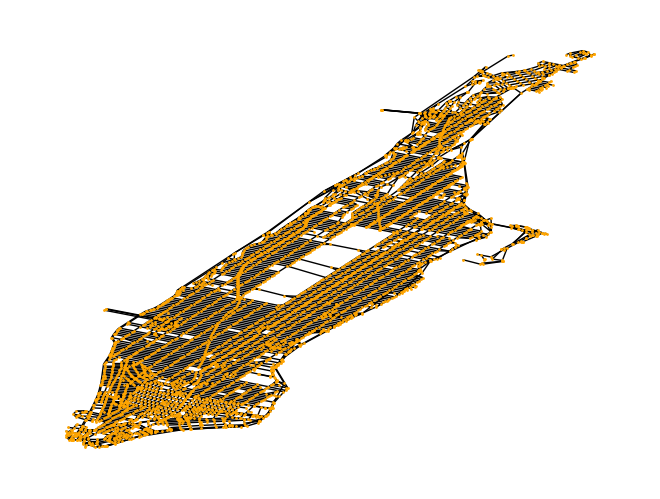

In [3]:
G = nx.Graph() #Creates the empty graph 
for index, row in df_nodes.iterrows(): 
    G.add_node(row['osmid'], pos=(row['x'], row['y'])) #Appends the graph G with the nodes
for index, row in df_street.iterrows():
    G.add_edge(row['u'], row['v'], weight=row['length']) #Appends the graph G with the length for the weights 
    
G.remove_edges_from(nx.selfloop_edges(G)) #Removes the self loops from the graph 

plt.figure() #Creates the figure 
pos = nx.get_node_attributes(G, "pos") #Gets the positional arguement 
nx.draw(G,pos, with_labels=False, node_size=1, node_color='orange') #Plots the graph 
plt.show() #Shows the figure 

### skip2gram approach

In [5]:

node2vec = Node2Vec(G, dimensions=32, walk_length=50, num_walks=300 , workers = 8) #Uses the node2vec library 


Generating walks (CPU: 8): 100%|██████████| 37/37 [00:36<00:00,  1.02it/s]


In [6]:
model = node2vec.fit(window=10, min_count=1, batch_words=4) # https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

### Matrix factorization

In [7]:
node_ids= model.wv.index_to_key
node_ids =list(map(int, node_ids))
node_embeddings = model.wv.vectors #Matrix Factorization

In [8]:
L = nx.laplacian_matrix(G).todense()
eigenvalues, eigenvectors = np.linalg.eig(L)

<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


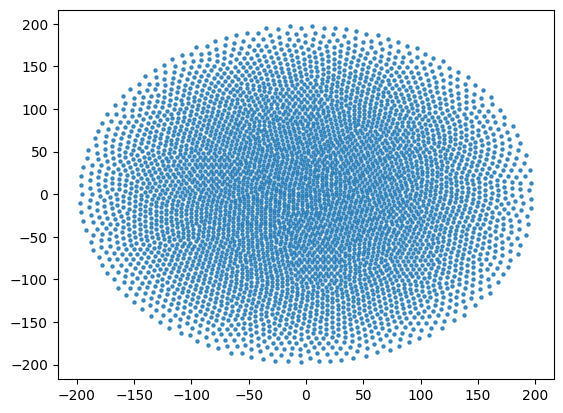

In [9]:
tsne = sk.TSNE(n_components=2)
node_embeddings_2d_l = tsne.fit_transform(eigenvectors)

plt.scatter(node_embeddings_2d_l[:,0], node_embeddings_2d_l[:,1],s=5, alpha = 0.8)

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


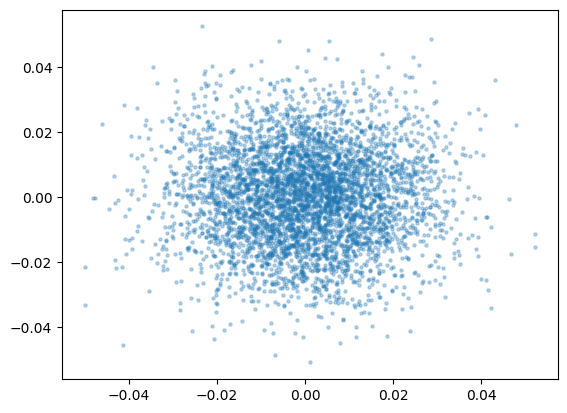

In [57]:
#PCA
PCA = skd.PCA(n_components=2)
node_embeddings_2d_P = PCA.fit_transform(eigenvectors)

plt.scatter(node_embeddings_2d_P[:,0], node_embeddings_2d_P[:,1], s=5, alpha = 0.3)

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


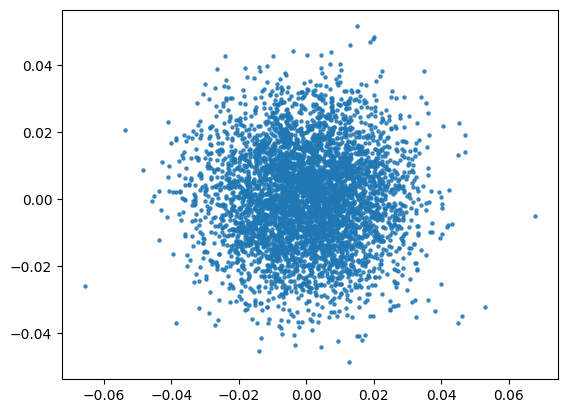

In [54]:
SVD = skd.svd = skd.TruncatedSVD()
node_embeddings_2d_S = SVD.fit_transform(eigenvectors)

plt.scatter(node_embeddings_2d_S[:,0], node_embeddings_2d_S[:,1],s=5, alpha = 0.8)

### Plot Network Embeddings 

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


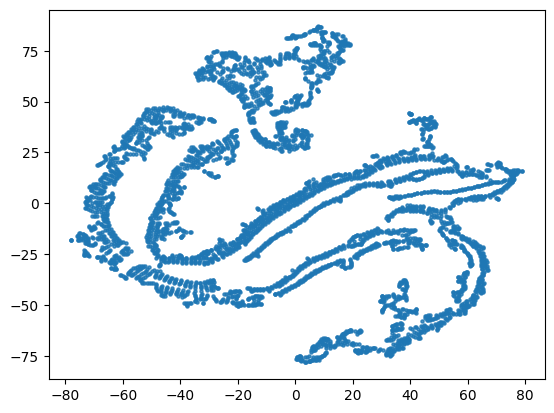

In [12]:
#TSNE 
tsne = sk.TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d[:,0], node_embeddings_2d[:,1],s=5, alpha = 0.8)

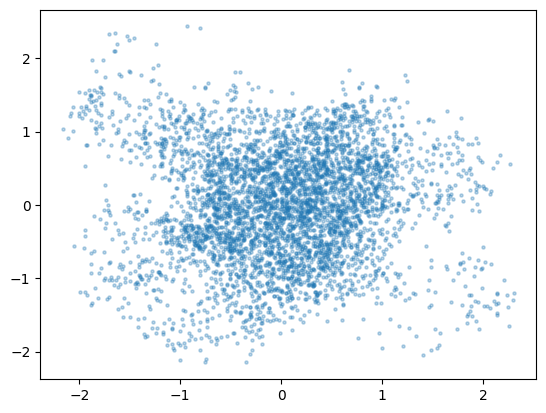

In [53]:
#PCA
pca = skd.PCA()
node_embeddings_2d_2 = pca.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d_2[:,0], node_embeddings_2d_2[:,1], s=5, alpha = 0.3)

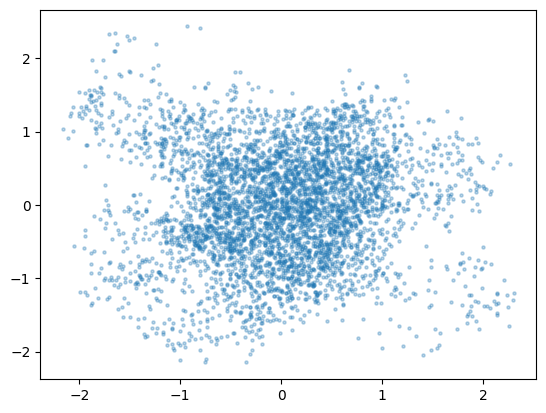

In [46]:
#SVD
svd = skd.TruncatedSVD()
node_embeddings_2d_3 = pca.fit_transform(node_embeddings)

plt.scatter(node_embeddings_2d_3[:,0], node_embeddings_2d_3[:,1],s=5, alpha = 0.3)

### KMeans Clustering 

In [35]:

kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=50, random_state=0)
kmeans.fit(node_embeddings)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')



/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/geopandas/plotting.py:649: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


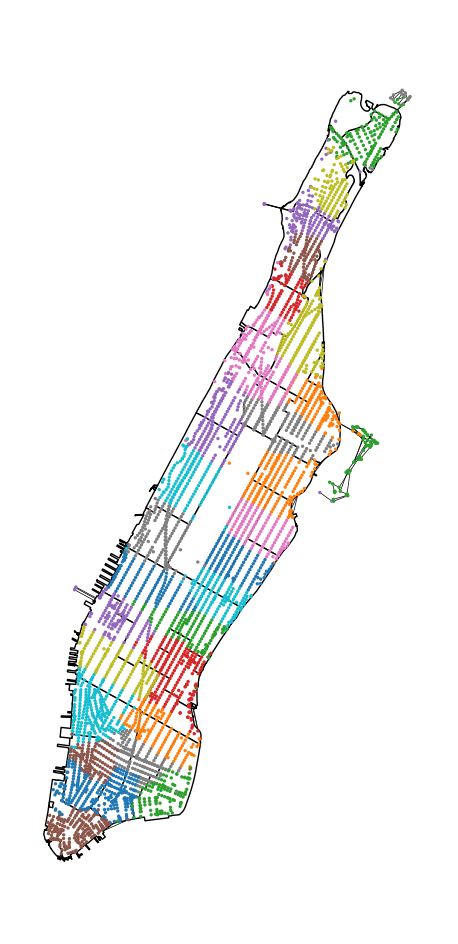

In [36]:
man_shape = gpd.read_file('shapefile/manhattan.shp')

pf, ax = plt.subplots(1, figsize=(12, 12))
nx.draw(G, pos, node_size=2, width=0.5, edge_color='black', node_color=nodes_clustered["cluster_label"], cmap = plt.cm.tab10, ax=ax)
man_shape.plot(axes=ax, color='white', edgecolor='black', ax=ax)
ax.set_axis_off()
plt.show()

In [44]:
#With SVD
kmean2 = skc.KMeans(n_clusters=32, init='k-means++', n_init=12, random_state=0)
kmean2.fit(node_embeddings_2d_2)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmean2.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered2 = df_nodes.merge(node_cluster_labels, on='osmid')

In [39]:
print(nodes_clustered2["cluster_label"])

0        9
1        9
2       20
3       20
4        3
        ..
4584    12
4585    18
4586    24
4587     9
4588     9
Name: cluster_label, Length: 4589, dtype: int32


/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/geopandas/plotting.py:649: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


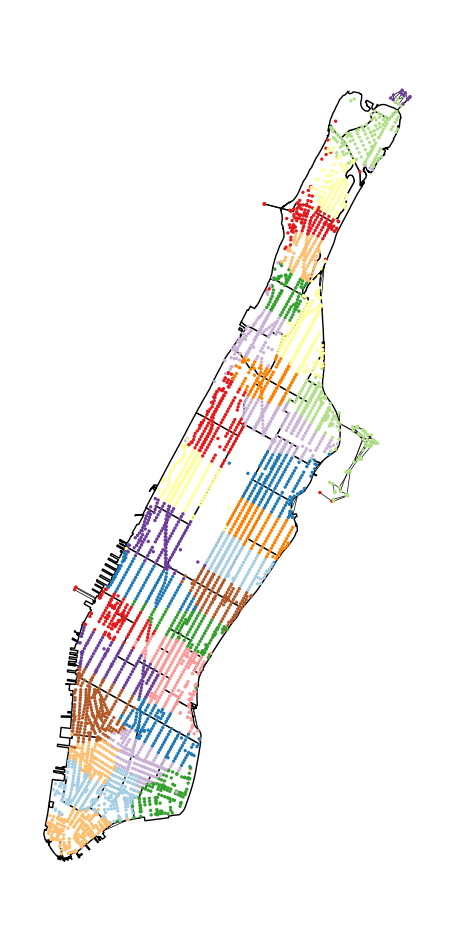

In [45]:
#With PCA
pf, ax = plt.subplots(1, figsize=(12, 12))
nx.draw(G, pos, node_size=2, width=0.5, edge_color='black', node_color=nodes_clustered2["cluster_label"], cmap = plt.cm.Paired, ax=ax)
man_shape.plot(axes=ax, color='white', edgecolor='black', ax=ax)
ax.set_axis_off()
plt.show()

In [47]:
#With SVD 

kmeans = skc.KMeans(n_clusters=32, init='k-means++', n_init=10, random_state=0)
kmeans.fit(node_embeddings_2d_3)

node_cluster_labels = pd.DataFrame(zip(node_ids, kmeans.labels_)).rename(columns={0:'osmid', 1:'cluster_label'})

nodes_clustered = df_nodes.merge(node_cluster_labels, on='osmid')

/Users/wdaugherty/ECE 5260/ECE-5260-Graph-Based-Data-Science-for-Networked-Systems/venv/lib/python3.9/site-packages/geopandas/plotting.py:649: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


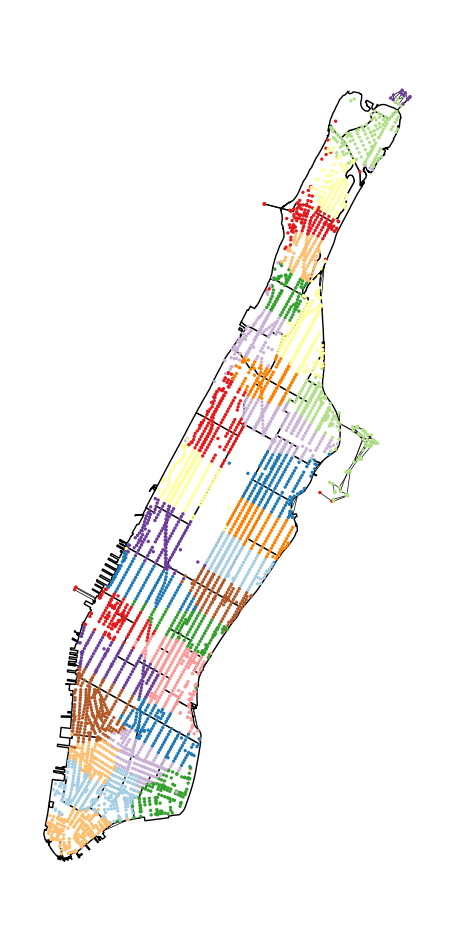

In [48]:
#With SVD
pf, ax = plt.subplots(1, figsize=(12, 12))
nx.draw(G, pos, node_size=2, width=0.5, edge_color='black', node_color=nodes_clustered["cluster_label"], cmap = plt.cm.Paired, ax=ax)
man_shape.plot(axes=ax, color='white', edgecolor='black', ax=ax)
ax.set_axis_off()
plt.show()

In [21]:
kmeans3 = skc.KMeans(n_clusters=32)
kmeans3.fit(node_embeddings_2d_l)
ykmeans = kmeans3.predict(node_embeddings_2d_l)

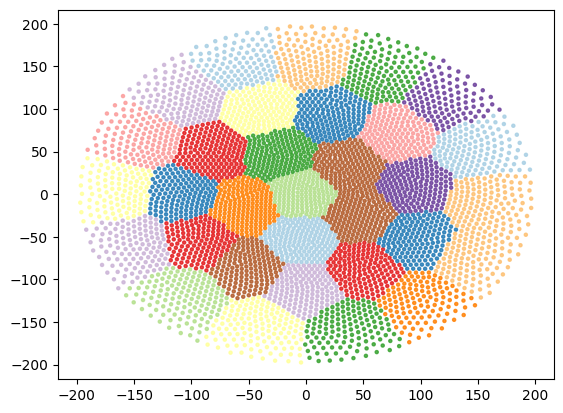

In [22]:
#With SVD
plt.figure()
plt.scatter(node_embeddings_2d_l[:,0], node_embeddings_2d_l[:,1],s=5, alpha = 0.8, c= ykmeans, cmap = plt.cm.Paired)
plt.show()

In [58]:
kmeans4 = skc.KMeans(n_clusters=32)
kmeans4.fit(node_embeddings_2d_P)
ykmeans4 = kmeans4.predict(node_embeddings_2d_P)

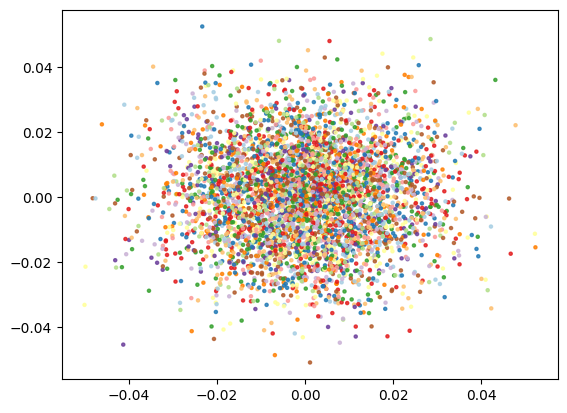

In [59]:
#With SVD
plt.figure()
plt.scatter(node_embeddings_2d_P[:,0], node_embeddings_2d_P[:,1],s=5, alpha = 0.8, c= ykmeans, cmap = plt.cm.Paired)
plt.show()

In [60]:
kmeans5 = skc.KMeans(n_clusters=32)
kmeans5.fit(node_embeddings_2d_S)
ykmeans5 = kmeans5.predict(node_embeddings_2d_S)

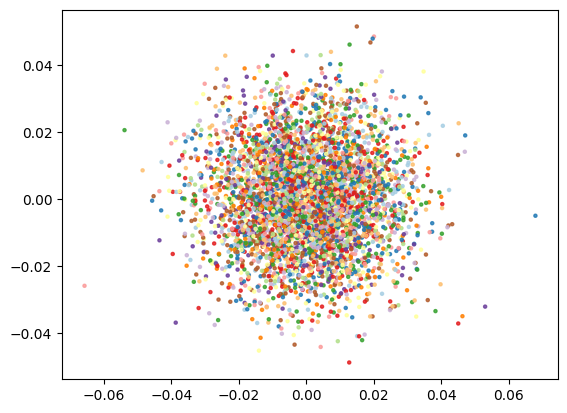

In [61]:
#With SVD
plt.figure()
plt.scatter(node_embeddings_2d_S[:,0], node_embeddings_2d_S[:,1],s=5, alpha = 0.8, c= ykmeans, cmap = plt.cm.Paired)
plt.show()